In [16]:
#!pip install scikit-survival

In [17]:
#Librerias a cargar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from sksurv.nonparametric import kaplan_meier_estimator

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

# Problema

El problema que el modelo predictivo busca resolver es **predecir la supervivencia de los pacientes con insuficiencia cardíaca** en función de sus características clínicas, corporales y de estilo de vida. El objetivo es desarrollar un modelo que, con base en estos datos, pueda determinar si un paciente tiene mayor probabilidad de sobrevivir o no dentro del periodo de seguimiento.

Este tipo de modelo ayudaría a los médicos a identificar a los pacientes con mayor riesgo de mortalidad y a priorizar intervenciones o tratamientos específicos para mejorar su pronóstico. Además, busca **identificar las características más influyentes** en la predicción de la supervivencia, lo que podría guiar futuras investigaciones y mejorar el manejo clínico de estos pacientes.

El propósito principal del dataset es predecir, mediante machine learning, la probabilidad de supervivencia de los pacientes y determinar cuáles son las características más importantes que influyen en este resultado. La variable objetivo es un evento de muerte (si el paciente murió o sobrevivió antes del final del período de seguimiento).

In [18]:
#Se cargan los datos en un dataframe
df = pd.read_csv('./data/heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [19]:
print(df.shape)
df.describe()

(299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


Este conjunto de datos contiene los registros médicos de 299 pacientes con insuficiencia cardíaca, recolectados en dos hospitales de Faisalabad, Pakistán, durante 2015. El dataset incluye 13 características que abarcan información clínica, corporal y de estilo de vida, como la presencia de anemia, hipertensión, diabetes, los niveles de creatinina y sodio en sangre, y la fracción de eyección del corazón.

1.   Cerca de las 2/5 partes de la muestra tuvo o anemía, diabetes o presión alta
2.   La 1/3 parte son mujeres
3.   2/3 partes no fuman
4.   1/3 murió en el periodo de seguimiento
5.   El rango de edad está entre 40 y 95 años
6.   El rango del periodo de seguimiento està entre 0 y 285 días



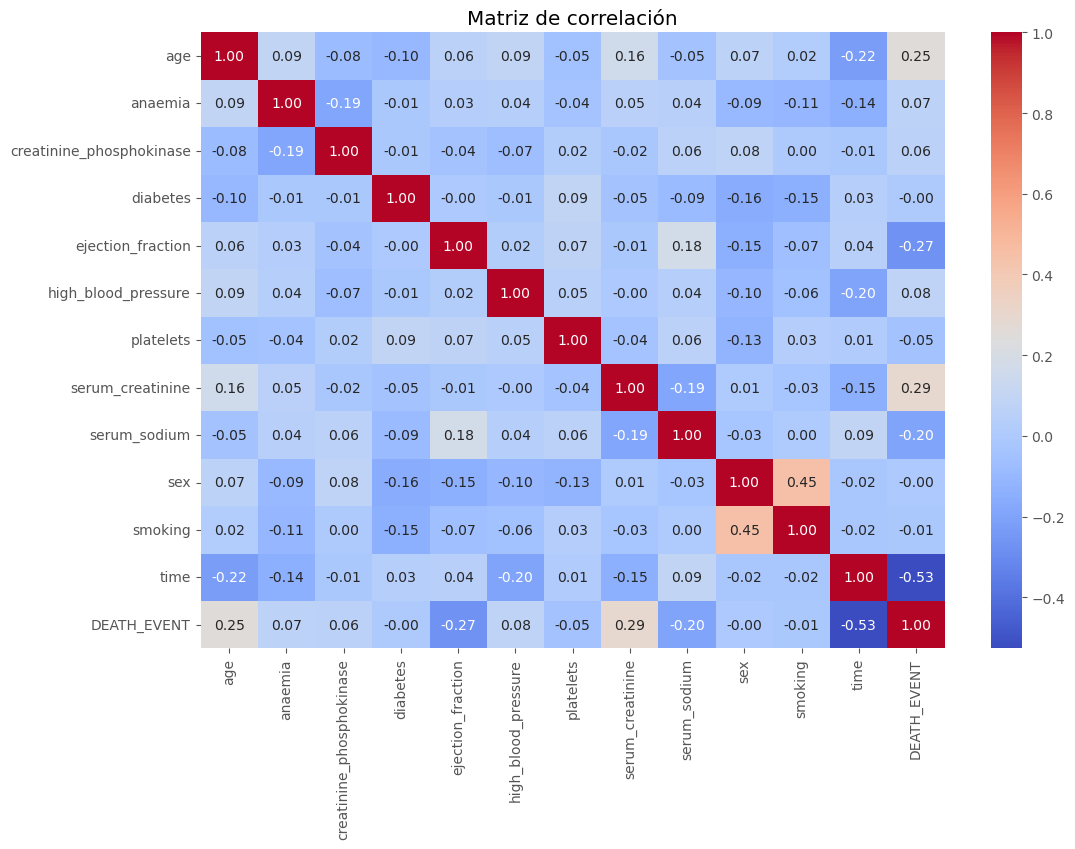

In [20]:
#Gráfico de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

Analizando la matriz de correlación presentada, podemos obtener varias conclusiones importantes sobre los factores que se relacionan con la mortalidad por insuficiencia cardíaca:

1. Correlaciones más fuertes con DEATH_EVENT:

- La edad muestra una correlación positiva (0.25) con la mortalidad, indicando que pacientes mayores tienen mayor riesgo.
- La fracción de eyección tiene una correlación negativa (-0.27), sugiriendo que una menor función cardíaca aumenta el riesgo de muerte.
- El nivel de creatinina sérica muestra una correlación positiva (0.29), indicando que niveles más altos están asociados con mayor mortalidad.

2. Correlaciones interesantes entre variables:

- Sexo y tabaquismo están moderadamente correlacionados (0.45), sugiriendo una mayor prevalencia de fumadores en uno de los géneros.
- La mayoría de las variables médicas muestran correlaciones débiles entre sí, lo que sugiere que son factores relativamente independientes.

3. Variables con correlaciones débiles con DEATH_EVENT:

- La diabetes, la presión arterial alta y las plaquetas muestran correlaciones muy débiles con la mortalidad (cerca de 0), sugiriendo que no son predictores fuertes de manera independiente.
- La anemia muestra una correlación débil positiva (0.07) con la mortalidad.

4. Observaciones clínicas relevantes:

- Los factores más importantes para predecir la mortalidad parecen ser el tiempo de seguimiento, la función cardíaca (fracción de eyección), la edad y la función renal (creatinina sérica).
- La mayoría de las comorbilidades (diabetes, hipertensión) tienen un impacto relativamente menor en la mortalidad cuando se consideran de forma aislada.

Esta información puede ser valiosa para:
- Identificar pacientes de alto riesgo
- Priorizar el monitoreo de ciertos parámetros clínicos
- Desarrollar estrategias de intervención más efectivas
- Informar decisiones sobre el manejo clínico de los pacientes

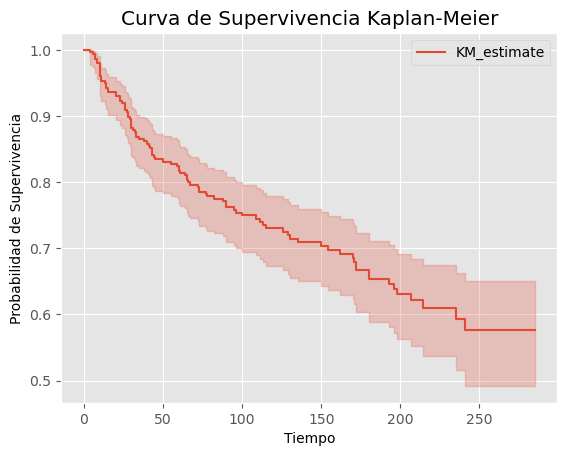

In [21]:
T = df['time'] # Tiempo hasta el evento o censura
E = df['DEATH_EVENT'] # Evento (1: muerte, 0:censura)

# PD: Censura es que mientras duro el experimento el individuo no presento el evento de interes (osea no murió)

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

# Graficar la curva de supervivencia
kmf.plot_survival_function()
plt.title('Curva de Supervivencia Kaplan-Meier')
plt.xlabel('Tiempo')
plt.ylabel('Probabilidad de Supervivencia')
plt.show()

La curva de Kaplan-Meier mostrada nos proporciona información valiosa sobre la supervivencia de los pacientes con insuficiencia cardíaca a lo largo del tiempo:

1. Supervivencia inicial:
- La curva comienza cerca del 100% de probabilidad de supervivencia
- Se observa una caída más pronunciada en los primeros 50 días, indicando que este es un período crítico para los pacientes

2. Tendencia general:
- La probabilidad de supervivencia disminuye de manera continua pero no lineal a lo largo del tiempo
- Aproximadamente a los 250 días, la probabilidad de supervivencia se estabiliza alrededor del 60%
- La pendiente de la curva se va suavizando con el tiempo, sugiriendo que el riesgo de muerte es mayor en los primeros meses

3. Intervalo de confianza:
- La banda azul clara alrededor de la curva representa el intervalo de confianza
- Este intervalo se ensancha a medida que avanza el tiempo, indicando mayor incertidumbre en las estimaciones a largo plazo
- Esto es típico en estudios de supervivencia, ya que hay menos pacientes en seguimiento en los períodos más largos

4. Implicaciones clínicas:
- Los primeros 50-100 días son cruciales para la supervivencia del paciente
- Pasado este período crítico inicial, la tasa de mortalidad se reduce
- Al final del período de seguimiento (cerca de los 300 días), aproximadamente el 60% de los pacientes sobreviven

Text(0.5, 1.02, 'Análisis de Variables en Relación con la Mortalidad')

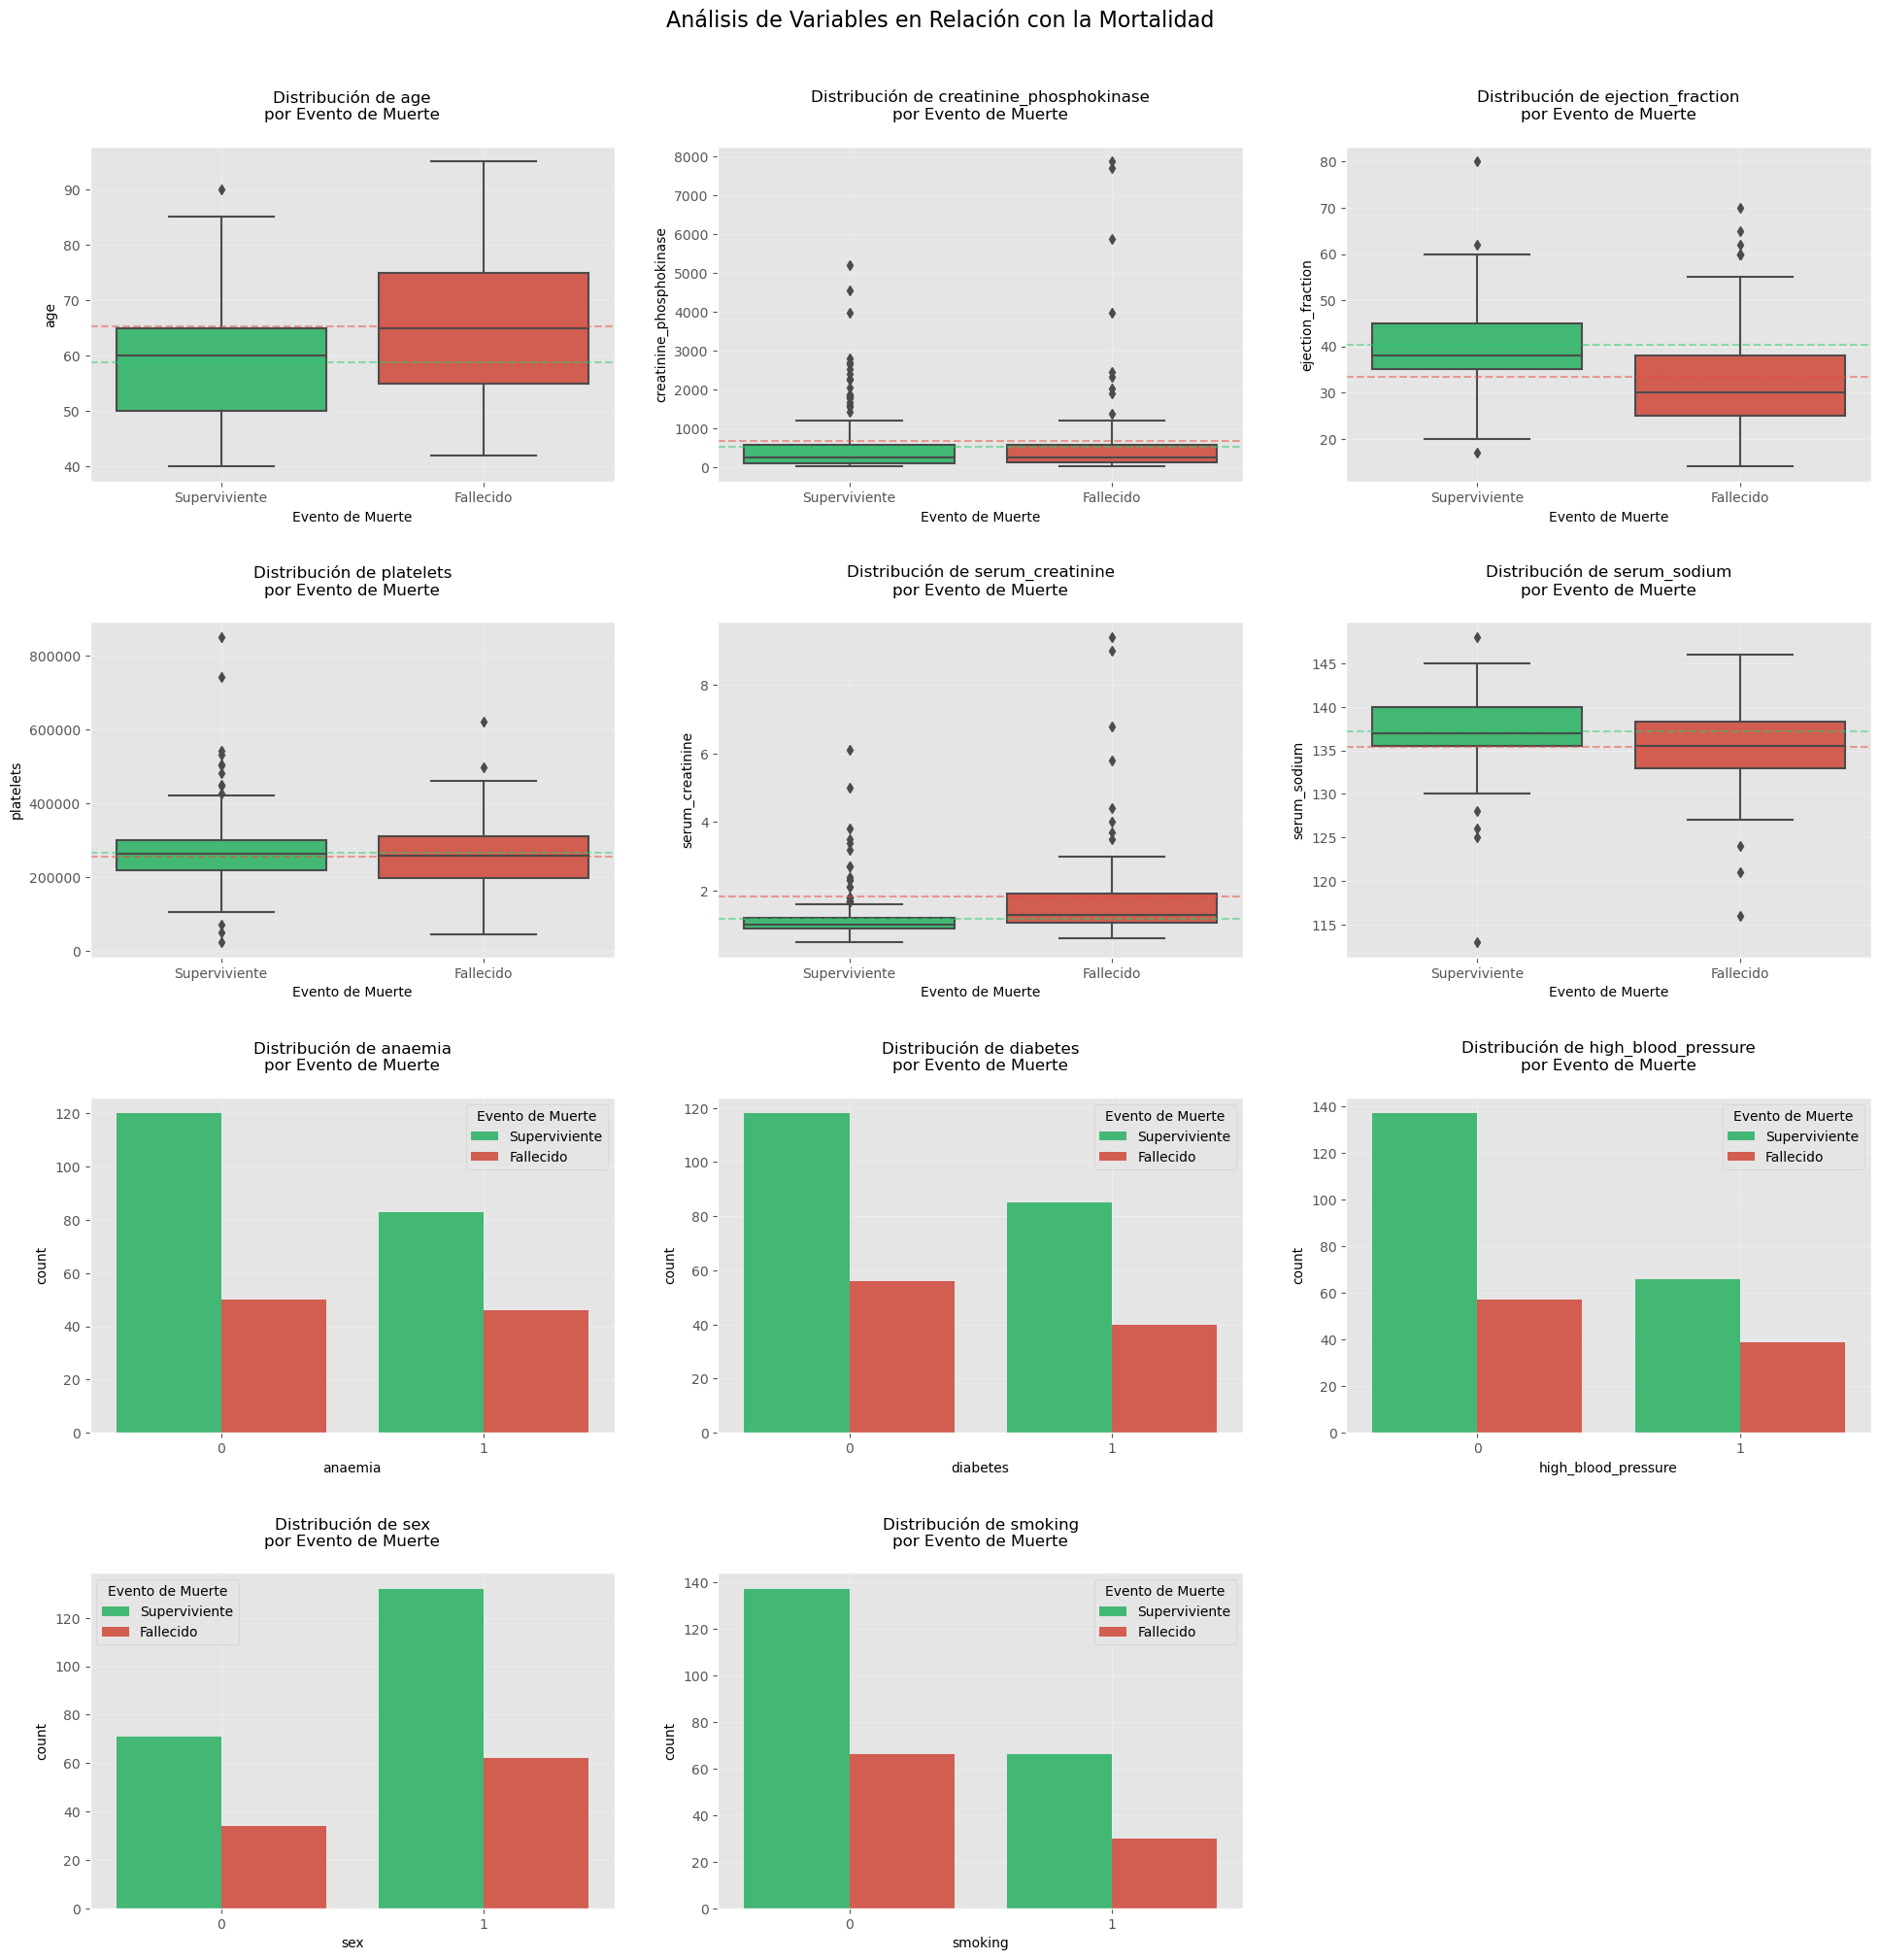

In [22]:
# Definir las variables a visualizar
num_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 
            'platelets', 'serum_creatinine', 'serum_sodium']
cat_vars = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

# Calcular el número total de subplots necesarios
total_plots = len(num_vars) + len(cat_vars)
rows = (total_plots + 2) // 3 

# Crear la figura principal con subplots
fig = plt.figure(figsize=(20, 5*rows))

# Configurar el estilo general
colors = ['#2ecc71', '#e74c3c']  # Verde para supervivientes, rojo para fallecidos

# Función para personalizar los boxplots
def customize_box(ax, title):
    ax.set_title(title, fontsize=12, pad=20)
    ax.set_xlabel('Evento de Muerte', fontsize=10)
    ax.set_xticklabels(['Superviviente', 'Fallecido'])
    ax.grid(True, alpha=0.3)
    
# Función para personalizar los countplots
def customize_count(ax, title):
    ax.set_title(title, fontsize=12, pad=20)
    ax.grid(True, alpha=0.3)
    
# Crear los subplots para variables numéricas
for i, var in enumerate(num_vars, 1):
    ax = plt.subplot(rows, 3, i)
    sns.boxplot(x='DEATH_EVENT', y=var, data=df, palette=colors, ax=ax)
    customize_box(ax, f'Distribución de {var}\npor Evento de Muerte')
    
    # Añadir valores estadísticos
    means = df.groupby('DEATH_EVENT')[var].mean()
    ax.axhline(y=means[0], color=colors[0], linestyle='--', alpha=0.5)
    ax.axhline(y=means[1], color=colors[1], linestyle='--', alpha=0.5)

# Crear los subplots para variables categóricas
for i, var in enumerate(cat_vars, len(num_vars) + 1):
    ax = plt.subplot(rows, 3, i)
    sns.countplot(x=var, hue='DEATH_EVENT', data=df, palette=colors, ax=ax)
    customize_count(ax, f'Distribución de {var}\npor Evento de Muerte')
    ax.legend(title='Evento de Muerte', labels=['Superviviente', 'Fallecido'])

# Ajustar el diseño
plt.tight_layout(pad=3.0)

# Añadir un título general
fig.suptitle('Análisis de Variables en Relación con la Mortalidad', 
            fontsize=16, y=1.02)


Analizando las diferentes gráficas, podemos extraer varias conclusiones importantes:

Variables Numéricas (Boxplots):

1. Edad (age):
- Los pacientes fallecidos tienden a ser mayores
- La mediana de edad es más alta en el grupo de fallecidos
- Hay mayor dispersión en las edades de los supervivientes

2. Fracción de eyección (ejection_fraction):
- Los supervivientes muestran valores más altos (mejor función cardíaca)
- Diferencia notable en las medianas entre grupos
- Valores más bajos están asociados con mayor mortalidad

3. Creatinina sérica (serum_creatinine):
- Los fallecidos tienen niveles más altos
- Mayor variabilidad en el grupo de fallecidos
- Varios valores atípicos en ambos grupos

4. Sodio sérico (serum_sodium):
- Diferencias pequeñas entre grupos
- Ligera tendencia a valores más bajos en fallecidos
- Bastante superposición entre grupos

5. Plaquetas (platelets):
- No hay diferencias muy marcadas entre grupos
- Varios valores atípicos en ambos grupos
- No parece ser un predictor fuerte de mortalidad

Variables Categóricas (Gráficas de barras):

1. Anemia:
- Mayor proporción de fallecimientos en pacientes con anemia
- La presencia de anemia parece aumentar el riesgo

2. Diabetes:
- Distribución similar entre supervivientes y fallecidos
- No parece tener un impacto muy fuerte en la mortalidad

3. Presión arterial alta (high_blood_pressure):
- Ligera tendencia a mayor mortalidad en hipertensos
- El efecto no es muy pronunciado

4. Sexo:
- Mayor proporción de hombres en la muestra
- La proporción de fallecimientos parece similar entre géneros

5. Tabaquismo (smoking):
- Los no fumadores tienen una proporción ligeramente mejor de supervivencia
- El efecto no parece ser muy pronunciado

Conclusiones generales:
- Los factores más importantes para la supervivencia parecen ser:
  * La edad
  * La fracción de eyección
  * Los niveles de creatinina sérica
- Las comorbilidades (diabetes, hipertensión) tienen un impacto menos marcado
- Hay una clara interacción entre factores de riesgo
- La visualización sugiere que un enfoque multifactorial es necesario para evaluar el riesgo de mortalidad

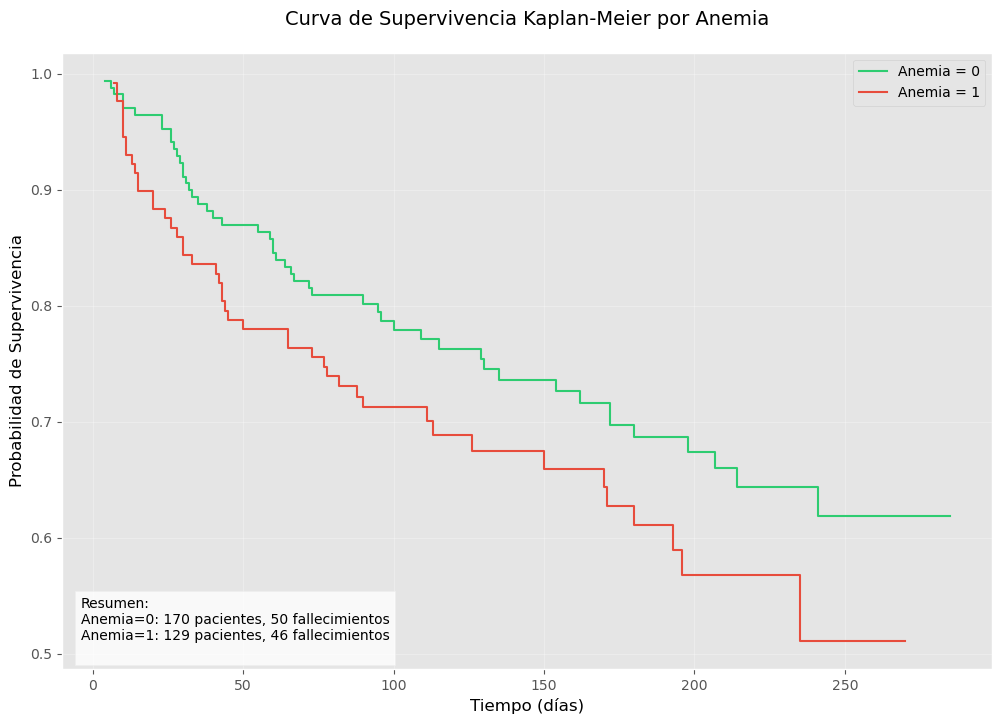

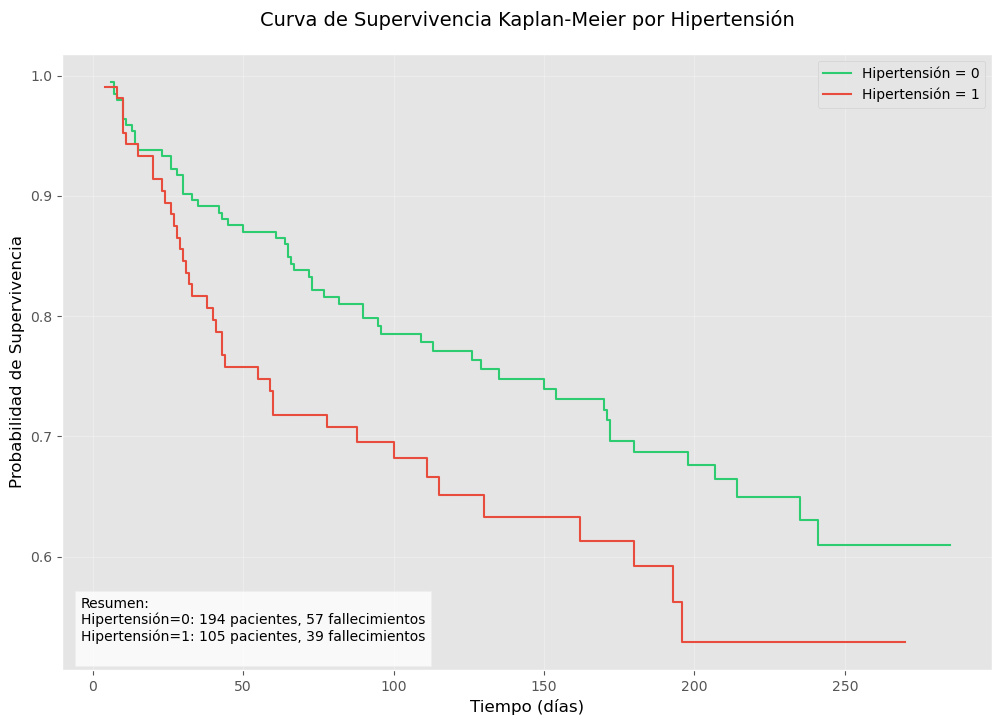

In [23]:
# Preparar los datos para scikit-survival
def prepare_survival_data(df):
    # Crear estructura de datos para scikit-survival
    survival_data = np.zeros(len(df), dtype=[('Status', bool), ('Survival_in_days', float)])
    survival_data['Status'] = df['DEATH_EVENT'].astype(bool)
    survival_data['Survival_in_days'] = df['time']
    return survival_data

def plot_survival_by_factor(df, factor, factor_name):
    # Preparar datos
    survival_data = prepare_survival_data(df)
    
    # Crear figura
    plt.figure(figsize=(12, 8))
    
    # Colores para las curvas
    colors = ['#2ecc71', '#e74c3c']  # Verde para no, rojo para sí
    
    # Calcular y graficar KM para cada grupo
    for i, value in enumerate(sorted(df[factor].unique())):
        mask = df[factor] == value
        time, survival_prob = kaplan_meier_estimator(
            survival_data[mask]['Status'],
            survival_data[mask]['Survival_in_days']
        )
        
        label = f'{factor_name} = {value}'
        plt.step(time, survival_prob, where="post", label=label, color=colors[i])
        
    # Personalizar gráfico
    plt.grid(True, alpha=0.3)
    plt.xlabel('Tiempo (días)', fontsize=12)
    plt.ylabel('Probabilidad de Supervivencia', fontsize=12)
    plt.title(f'Curva de Supervivencia Kaplan-Meier por {factor_name}', fontsize=14, pad=20)
    plt.legend(loc='best')
    
    # Añadir texto explicativo
    factor_counts = df[factor].value_counts()
    total_deaths = df.groupby(factor)['DEATH_EVENT'].sum()
    
    text_info = "Resumen:\n"
    for value in sorted(df[factor].unique()):
        n_patients = factor_counts[value]
        n_deaths = total_deaths[value]
        text_info += f"{factor_name}={value}: {n_patients} pacientes, {n_deaths} fallecimientos\n"
    
    plt.text(0.02, 0.02, text_info, transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8), fontsize=10)
    
    return plt

# Anemia
plot_survival_by_factor(df, 'anaemia', 'Anemia')
plt.show()

# Hipertensión
plot_survival_by_factor(df, 'high_blood_pressure', 'Hipertensión')
plt.show()

A partir de la curva de Kaplan-Meier por anemia, se pueden extraer conclusiones significativas:

1. **Diferencias en Supervivencia:**
   - Los pacientes sin anemia (Anemia = 0, línea verde) presentan una probabilidad de supervivencia superior a lo largo del seguimiento en comparación con los pacientes con anemia (Anemia = 1, línea roja), quienes muestran una menor probabilidad en todos los puntos temporales.

2. **Patrones Temporales:**
   - Las diferencias en supervivencia se hacen evidentes en los primeros 50 días, con una separación más pronunciada en los primeros 100 días. A partir de los 200 días, aunque la diferencia persiste, las curvas tienden a estabilizarse.

3. **Magnitud del Efecto:**
   - Al finalizar el seguimiento (≈250 días), la probabilidad de supervivencia es:
     * Sin anemia: ~62%
     * Con anemia: ~52%
   - Esto indica una diferencia de aproximadamente 10% en la supervivencia a largo plazo.

4. **Composición de la Muestra:**
   - Pacientes sin anemia: 170, 50 fallecimientos (29.4% de mortalidad).
   - Pacientes con anemia: 129, 46 fallecimientos (35.7% de mortalidad).
   - La tasa de mortalidad es un 6.3% mayor en el grupo con anemia.

5. **Implicaciones Clínicas:**
   - La anemia se identifica como un factor pronóstico crítico en la insuficiencia cardíaca. 
   - El manejo adecuado de la anemia podría mejorar los resultados clínicos, sugiriendo que estos pacientes necesitan un seguimiento más cercano.
   - La intervención temprana es esencial, dado que las diferencias en supervivencia se manifiestan desde el inicio del seguimiento.

En relación con la curva de Kaplan-Meier por hipertensión, se destacan las siguientes conclusiones:

1. **Mortalidad:**
   - Grupo sin hipertensión: 57 fallecimientos (29.4%).
   - Grupo con hipertensión: 39 fallecimientos (37.1%).

2. **Diferencias en Supervivencia:**
   - La curva correspondiente al grupo sin hipertensión muestra una mejor supervivencia en comparación con el grupo hipertenso.
   - La separación entre las curvas es notable a partir de los primeros 50 días, con una diferencia de aproximadamente 10 puntos porcentuales en la probabilidad de supervivencia al final del seguimiento.

3. **Patrones Temporales:**
   - La mayor disminución en la supervivencia se observa en los primeros 100 días, tras los cuales las curvas se estabilizan, aunque continúan descendiendo gradualmente.
   - Al final del seguimiento, las tasas de supervivencia son aproximadamente:
     * Sin hipertensión: 61%
     * Con hipertensión: 52%.

4. **Implicaciones Clínicas:**
   - La hipertensión se asocia con un impacto negativo en la supervivencia, especialmente crítico en los primeros 100 días.
   - Se recomienda un seguimiento más estrecho para los pacientes hipertensos durante este período inicial.

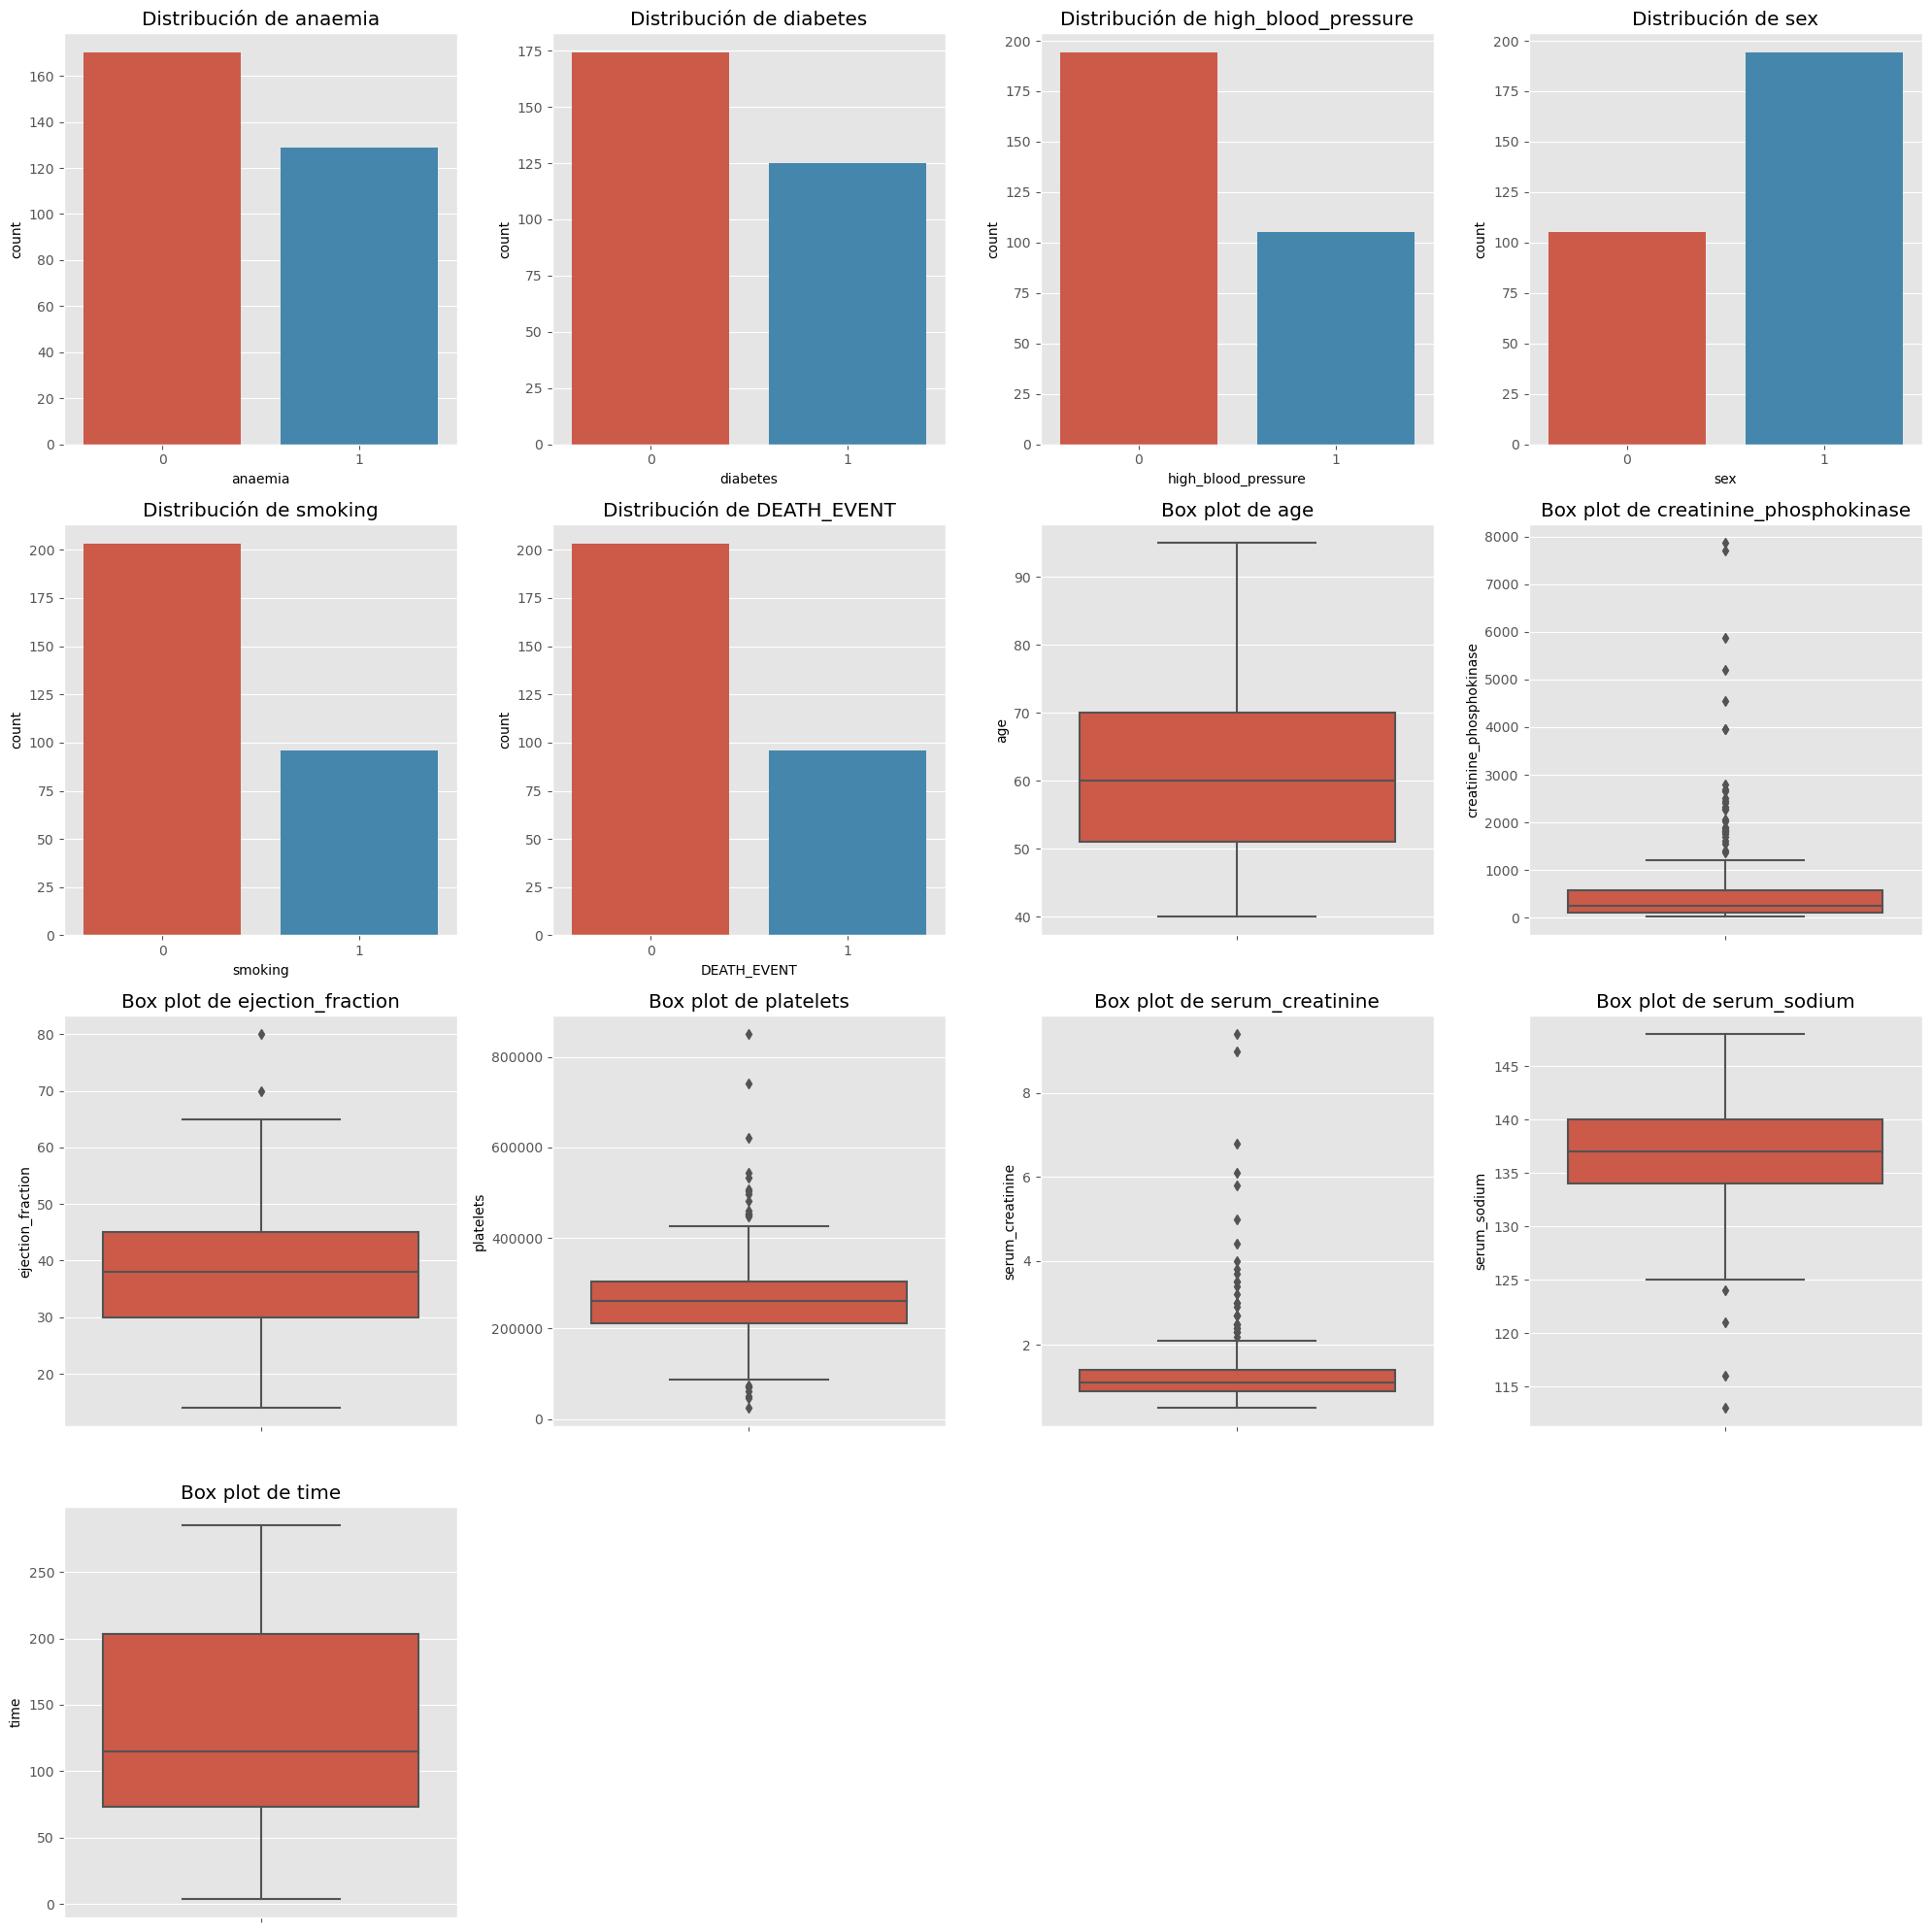

In [24]:
# Gráficas de las variables
# Se identifican las columnas binarias para graficar en barras
binary_cols = [col for col in df.columns if set(df[col].unique()) == {0, 1}]
# Las otras columnas se grafican con un box plot
other_cols = [col for col in df.columns if col not in binary_cols]
# Nùmero de filas del gráfico
num_rows = int(np.ceil((len(binary_cols) + len(other_cols)) / 4))
plt.figure(figsize=(20, 5 * num_rows))
# Gráfico para columnas binarias
for i, col in enumerate(binary_cols):
    plt.subplot(num_rows, 4, i + 1)
    sns.countplot(x=col, data=df)
    plt.title(f'Distribución de {col}')
# Gráfico para las otras columnas
for i, col in enumerate(other_cols):
    plt.subplot(num_rows, 4, i + 1 + len(binary_cols))
    sns.boxplot(y=col, data=df)
    plt.title(f'Box plot de {col}')
plt.tight_layout()
plt.show()